In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
def visualize_clusters(clusters, concat_data):
    # Get the number of unique clusters
    num_clusters = len(np.unique(clusters))

    # Plot clusters
    for cluster_num in range(1, num_clusters + 1):
        # Filter data points belonging to the current cluster
        selected_data = concat_data[clusters == cluster_num]

        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot individual triangles with transparent grey lines
        for i in range(len(selected_data)):
            x = [selected_data[i, 0], 0, 0]
            y = [0, selected_data[i, 1], 0]
            z = [0, 0, selected_data[i, 2]]

            # Plot points
            ax.scatter(x, y, z, marker='o', c='grey')

            # Connect the points to form a triangle with transparent grey lines
            ax.plot([x[0], x[1], x[2], x[0]], [y[0], y[1], y[2], y[0]], [z[0], z[1], z[2], z[0]], c='grey', alpha=0.1)

        # Calculate the average triangle
        average_triangle = np.mean(selected_data, axis=0)
        x_avg = [average_triangle[0], 0, 0]
        y_avg = [0, average_triangle[1], 0]
        z_avg = [0, 0, average_triangle[2]]

        # Plot the average triangle with black lines
        ax.plot(x_avg + [x_avg[0]], y_avg + [y_avg[0]], z_avg + [z_avg[0]], c='black')

        # Plot red lines along the x, y, and z axes
        ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
        ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
        ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

        #ax.plot(x_avg, y_avg, z_avg, c='black')
        # Set axis labels
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        # Set axis limits to range from -1 to 1
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f"{cluster_num} Cluster")

        # Show the plot
        plt.show()    

In [3]:
def plot_histogram(clusters):
    # Plot histogram
    plt.hist(clusters, bins=range(min(clusters), max(clusters) + 2), align='left', rwidth=0.8, color='skyblue', edgecolor='black')

    # Set labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of the Cluster Count')

    # Show the plot
    plt.show()

In [2]:
# Create an empty list to store arrays from each file
data_list = []
import os
import numpy as np

print(os.getcwd())
# Specify the directory
#directory = "0.5gcc_1000k_3bS/"
directory = "/Users/blaubach/chimes_CGD-myLLFork/cluster_analysis/1.0gcc_2000K_3B_graphs/1.0gcc_2000K_3B_graphs/1.0gcc_2000k_3bS/"
#directory = "/Users/blaubach/chimes_CGD-myLLFork/cluster_analysis/2.0gcc_6000K_3B_graphs/2.0gcc_6000k_3bS/"
# Set the desired subsample size
subsample_size = 1000
# Loop over the range of integers from 50 to 74
for i in range(75, 100):
    # Generate the filename
    filename = f'{directory}00{i}.3b_clu-s.txt'
    
    try:
        # Read the data from the file and append it to the list
        data = np.loadtxt(filename)
        sort_data = np.sort(data, axis=1)

        # Subsample the sorted data using random indices
        random_indices = np.random.choice(sort_data.shape[0], size=subsample_size, replace=False)
        subsampled_data = sort_data[random_indices, :]
        
        # data_list.append(sort_data) # Account for graph invariance
        data_list.append(subsampled_data)  # Account for graph invariance
    except FileNotFoundError:
        print(f"File not found: {filename}")

# Concatenate the list of arrays along axis 0 (rows)
concat_data = np.concatenate(data_list, axis=0)


# Print the shape of concatenated data
print("Shape:", np.shape(concat_data))
concat_data

/Users/blaubach/chimes_CGD-myLLFork/cluster_analysis/0.5gcc_1000K_3B_graphs/0.5gcc_1000K_3B_graphs
Shape: (25000, 3)


array([[-0.978488, -0.886118, -0.400489],
       [-0.959036, -0.848955, -0.425264],
       [-0.840709, -0.314076, -0.303856],
       ...,
       [-0.96781 , -0.967056,  0.346002],
       [-0.863131, -0.58878 ,  0.562685],
       [-0.948999, -0.871836, -0.756198]])

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

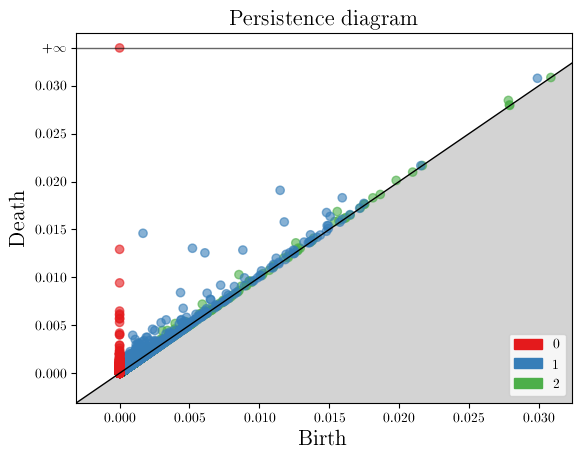

In [9]:
import matplotlib.pyplot as plt
import gudhi as gd

acX = gd.AlphaComplex(points=concat_data).create_simplex_tree()
dgmX = acX.persistence()

gd.plot_persistence_diagram(dgmX)

(25000, 25000)


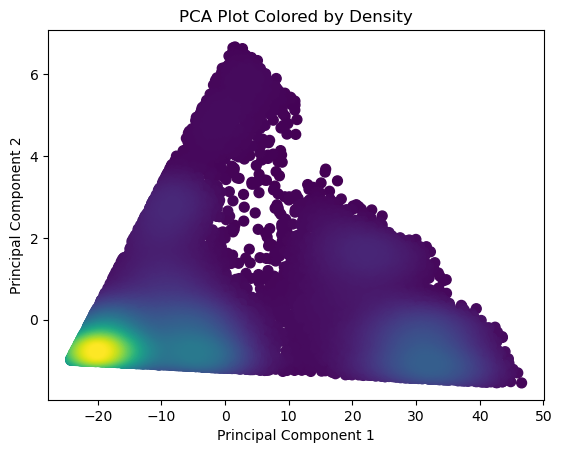

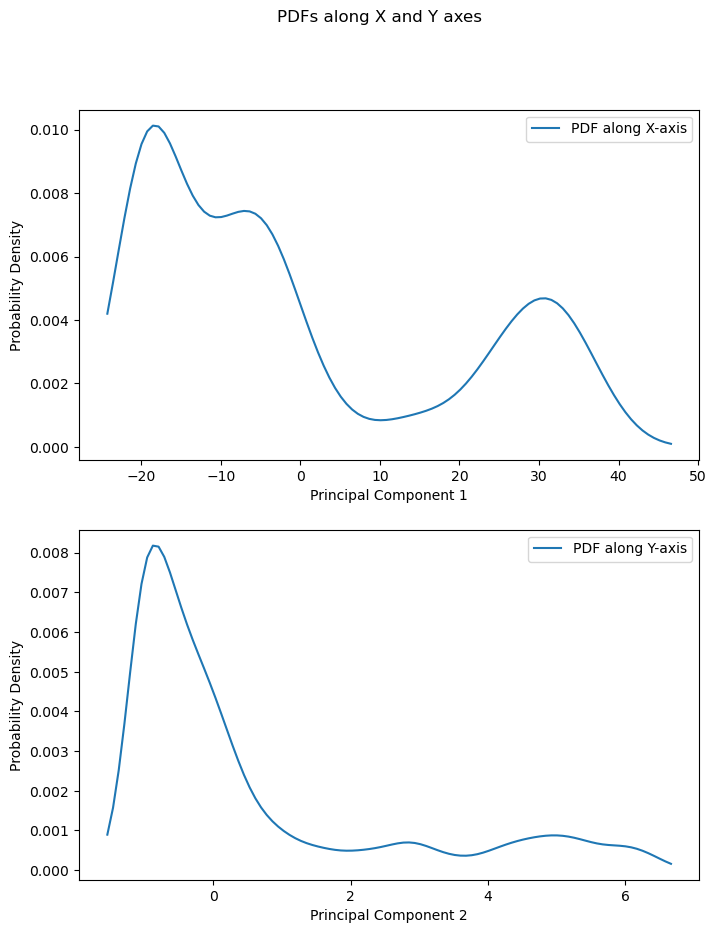

In [29]:
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import ndimage

Cov = np.cov(concat_data)
print(np.shape(Cov))
# Step 1: Perform PCA
pca = PCA(n_components=2)
X = pca.fit_transform(Cov)

first = X[:,0]
second = X[:,1]
xy = np.vstack([first, second])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
first, second, z = first[idx], second[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(first, second, c=z, s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot Colored by Density')
plt.show()

# Calculate 2D KDE
xy = np.vstack([first, second])
kde = gaussian_kde(xy)

# Define a range of values along each axis
x_range = np.linspace(min(first), max(first), 100)
y_range = np.linspace(min(second), max(second), 100)

# Calculate PDF along the x-axis
pdf_x = kde.evaluate([x_range, np.zeros_like(x_range)])

# Calculate PDF along the y-axis
pdf_y = kde.evaluate([np.zeros_like(y_range), y_range])

# Plot the PDFs
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].plot(x_range, pdf_x, label='PDF along X-axis')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Probability Density')
ax[0].legend()

ax[1].plot(y_range, pdf_y, label='PDF along Y-axis')
ax[1].set_xlabel('Principal Component 2')
ax[1].set_ylabel('Probability Density')
ax[1].legend()

plt.suptitle('PDFs along X and Y axes')
plt.show()
# # Estimate 2D density
# kde = sns.kdeplot(x=X[:, 0], y=X[:, 1], fill=True, cmap="viridis", levels=10)

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA Plot Colored by Density')
# plt.show()



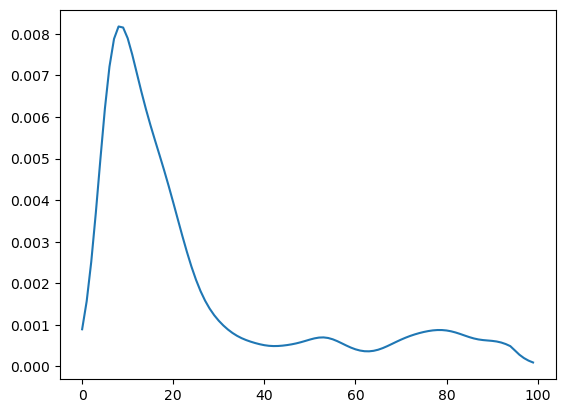

In [35]:
z_surf = np.minimum(pdf_x,pdf_y)
plt.plot(z_surf)

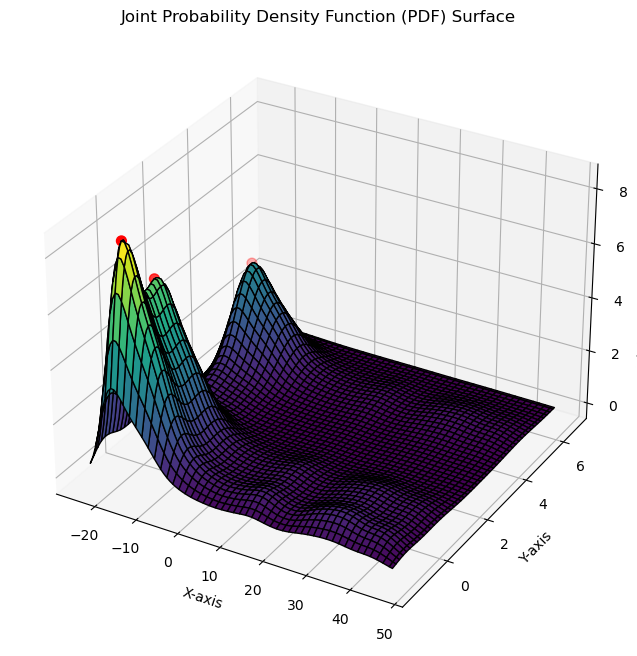

In [37]:
from scipy.ndimage import label, maximum_filter

# Create a meshgrid from x and y
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)

# Calculate the joint PDF based on the product of marginal PDFs
pdf_joint = pdf_x[:, np.newaxis] * pdf_y[np.newaxis, :]

# Plot the surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_mesh, Y_mesh, pdf_joint, cmap='viridis', edgecolor='k')

# Identify local maxima
labeled, num_features = label(pdf_joint == maximum_filter(pdf_joint, footprint=np.ones((3, 3))))

# Get coordinates of all local maxima
maxima_coordinates = np.argwhere(labeled > 0)

# Plot red dots at the maxima
ax.scatter(X_mesh[maxima_coordinates[:, 0], maxima_coordinates[:, 1]],
           Y_mesh[maxima_coordinates[:, 0], maxima_coordinates[:, 1]],
           pdf_joint[maxima_coordinates[:, 0], maxima_coordinates[:, 1]],
           c='red', s=50, label='Maxima')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Joint Probability Density')
ax.set_title('Joint Probability Density Function (PDF) Surface')

plt.show()

# Raw Data

In [1]:

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(concat_data[:, 0], concat_data[:, 1], concat_data[:, 2], c='blue', marker='o', edgecolors='black')

# Set labels for each axis
ax.set_xlabel('Side A')
ax.set_ylabel('Side B')
ax.set_zlabel('Side C')

# Set axis limits to range from -1 to 1
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Plot red lines along the x, y, and z axes
ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

# Show the plot
plt.show()

NameError: name 'plt' is not defined

KMeans Clustering

In [6]:
# Perform k-means clustering for a range of k values
silhouette_scores = []
k_values = range(2, 30)  # You can adjust the range of k values

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(concat_data)
    silhouette_scores.append(silhouette_score(concat_data, clusters))

# Plot the Silhouette Score curve
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

 18%|█▊        | 5/28 [00:16<01:16,  3.33s/it]


KeyboardInterrupt: 

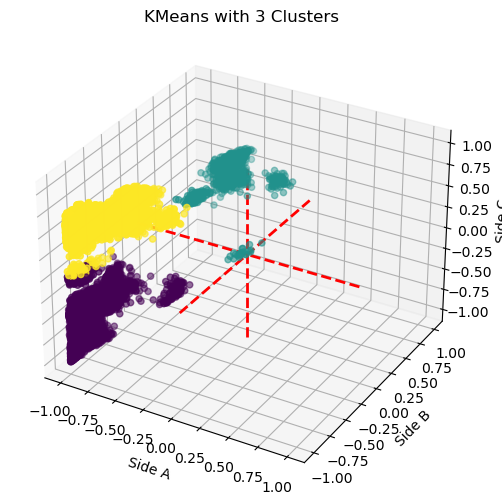

In [ ]:
# Perform k-means clustering with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(concat_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(concat_data[:, 0], concat_data[:, 1], concat_data[:, 2], c=labels, marker='o')
ax.set_xlabel('Side A')
ax.set_ylabel('Side B')
ax.set_zlabel('Side C')
ax.set_title(f'KMeans with {optimal_k} Clusters')

# Plot red lines along the x, y, and z axes
ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

plt.show()


In [ ]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

1
(7585, 3)
[-0.94574464 -0.80291415 -0.55801906]


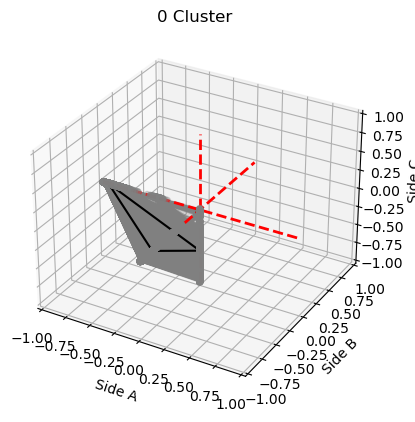

2
(1800, 3)
[-0.40567287  0.44982708  0.57899997]


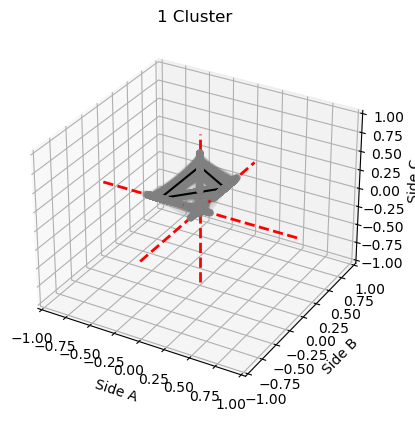

3
(9866, 3)
[-0.89811128 -0.71212928  0.55048501]


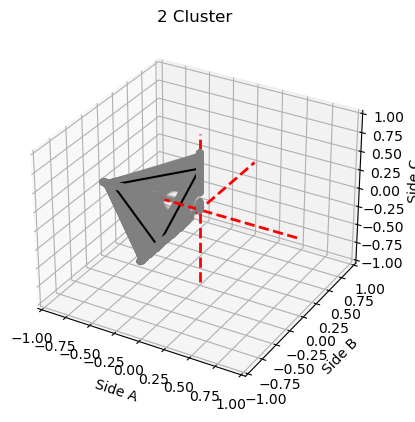

In [ ]:
# Get the number of unique clusters
num_clusters = len(np.unique(labels))
amounts = []

# Plot clusters
for cluster_num in range(1, num_clusters + 1):
    
    # Filter data points belonging to the current cluster
    selected_data = concat_data[labels == cluster_num-1]
    print(cluster_num)
    print(np.shape(selected_data))
    amounts.append(len(selected_data))
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot individual triangles with transparent grey lines
    for i in range(len(selected_data)):
        x = [selected_data[i, 0], 0, 0]
        y = [0, selected_data[i, 1], 0]
        z = [0, 0, selected_data[i, 2]]

        # Plot points
        ax.scatter(x, y, z, marker='o', c='grey')

        # Connect the points to form a triangle with transparent grey lines
        ax.plot([x[0], x[1], x[2], x[0]], [y[0], y[1], y[2], y[0]], [z[0], z[1], z[2], z[0]], c='grey', alpha=0.1)

    # Calculate the average triangle
    average_triangle = np.mean(selected_data, axis=0)
    print(average_triangle)
    x_avg = [average_triangle[0], 0, 0]
    y_avg = [0, average_triangle[1], 0]
    z_avg = [0, 0, average_triangle[2]]

    # Plot the average triangle with black lines
    ax.plot(x_avg + [x_avg[0]], y_avg + [y_avg[0]], z_avg + [z_avg[0]], c='black')

    # Plot red lines along the x, y, and z axes
    ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
    ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
    ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

    #ax.plot(x_avg, y_avg, z_avg, c='black')
    # Set axis labels
    ax.set_xlabel('Side A')
    ax.set_ylabel('Side B')
    ax.set_zlabel('Side C')
    
    # Set axis limits to range from -1 to 1
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"{cluster_num-1} Cluster")

    # Show the plot
    plt.show()    
    


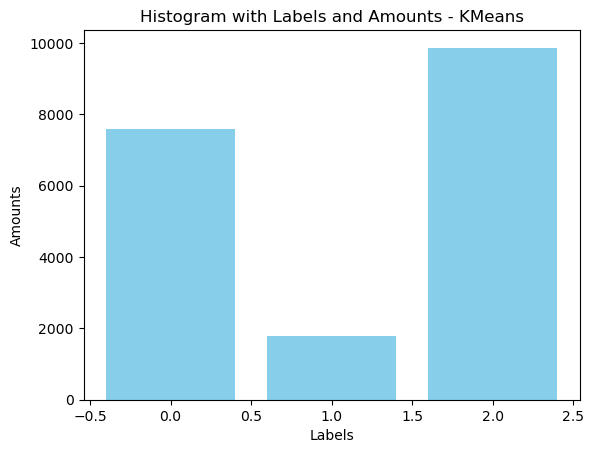

In [ ]:
# Create a bar plot
plt.bar(np.unique(labels), amounts, color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Amounts')
plt.title('Histogram with Labels and Amounts - KMeans')

# Show the plot
plt.show()

Hierarchical Clustering

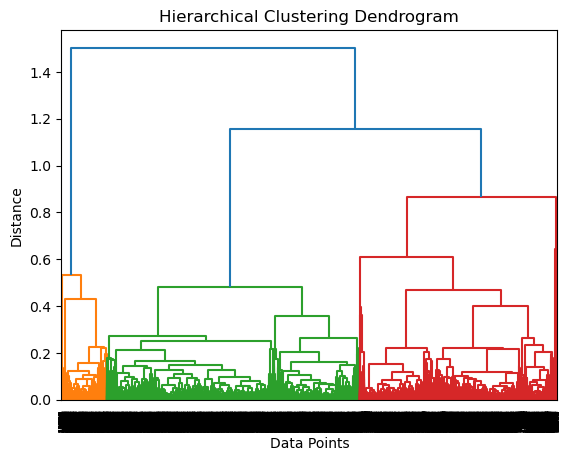

In [ ]:
# Calculate the linkage matrix using hierarchical clustering
linkage_matrix = linkage(concat_data, method='average')

# Plot the dendrogram
dendrogram(linkage_matrix, labels=np.arange(len(concat_data)), orientation='top')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

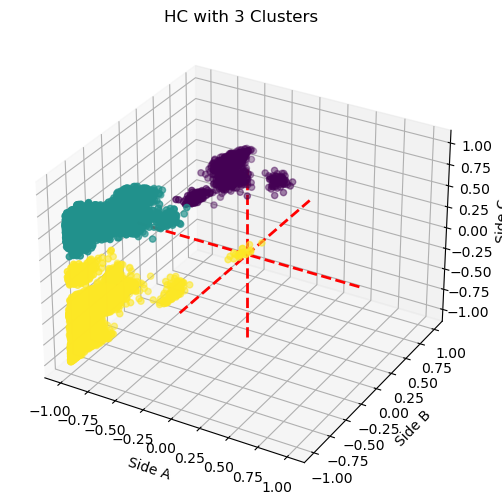

In [ ]:
# Choose a threshold to cut the dendrogram and form clusters
cutoff_height = 1.0 # Adjust this value based on your dendrogram

# Cut the dendrogram and get cluster assignments
labels = fcluster(linkage_matrix, t=cutoff_height, criterion='distance')

# Visualize the clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(concat_data[:, 0], concat_data[:, 1], concat_data[:, 2], c=labels, marker='o')
ax.set_xlabel('Side A')
ax.set_ylabel('Side B')
ax.set_zlabel('Side C')
ax.set_title(f'HC with {len(np.unique(labels))} Clusters')

# Plot red lines along the x, y, and z axes
ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

plt.show()

1
(1776, 3)
[-0.41059254  0.45607281  0.58668759]


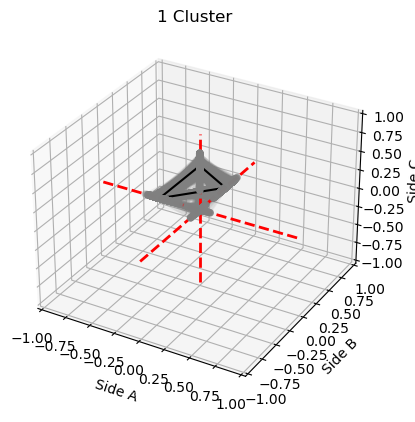

2
(9796, 3)
[-0.89766305 -0.71102615  0.55412416]


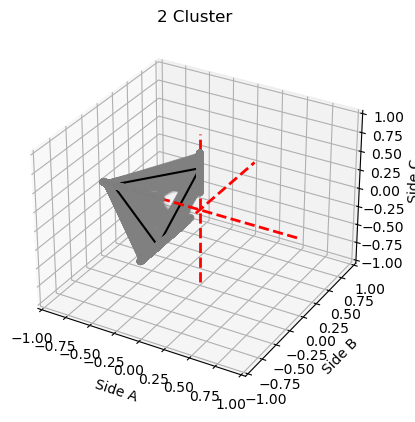

3
(7679, 3)
[-0.94305645 -0.80102301 -0.55078095]


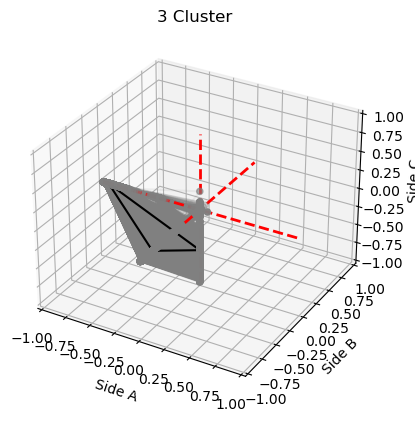

In [ ]:
# Get the number of unique clusters
num_clusters = len(np.unique(labels))
amounts = []

# Plot clusters
for cluster_num in range(1, num_clusters + 1):
    
    # Filter data points belonging to the current cluster
    selected_data = concat_data[labels == cluster_num]
    print(cluster_num)
    print(np.shape(selected_data))
    amounts.append(len(selected_data))
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot individual triangles with transparent grey lines
    for i in range(len(selected_data)):
        x = [selected_data[i, 0], 0, 0]
        y = [0, selected_data[i, 1], 0]
        z = [0, 0, selected_data[i, 2]]

        # Plot points
        ax.scatter(x, y, z, marker='o', c='grey')

        # Connect the points to form a triangle with transparent grey lines
        ax.plot([x[0], x[1], x[2], x[0]], [y[0], y[1], y[2], y[0]], [z[0], z[1], z[2], z[0]], c='grey', alpha=0.1)

    # Calculate the average triangle
    average_triangle = np.mean(selected_data, axis=0)
    print(average_triangle)
    x_avg = [average_triangle[0], 0, 0]
    y_avg = [0, average_triangle[1], 0]
    z_avg = [0, 0, average_triangle[2]]

    # Plot the average triangle with black lines
    ax.plot(x_avg + [x_avg[0]], y_avg + [y_avg[0]], z_avg + [z_avg[0]], c='black')

    # Plot red lines along the x, y, and z axes
    ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
    ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
    ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

    #ax.plot(x_avg, y_avg, z_avg, c='black')
    # Set axis labels
    ax.set_xlabel('Side A')
    ax.set_ylabel('Side B')
    ax.set_zlabel('Side C')
    
    # Set axis limits to range from -1 to 1
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"{cluster_num} Cluster")

    # Show the plot
    plt.show()    
    

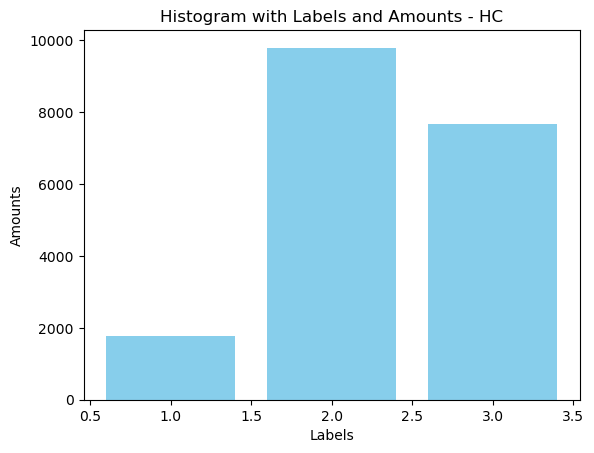

In [ ]:
# Create a bar plot
plt.bar(np.unique(labels), amounts, color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Amounts')
plt.title('Histogram with Labels and Amounts - HC')

# Show the plot
plt.show()

DBSCAN Clustering

100%|██████████| 30/30 [01:12<00:00,  2.43s/it]


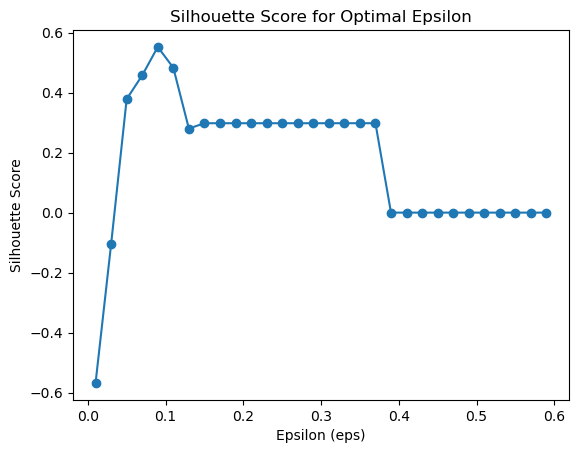

Optimal Epsilon (eps): 0.08999999999999998 with Silhouette Score: 0.5520678774596072


In [ ]:
# Set the range of eps values
eps_values = np.arange(0.01, 0.6, 0.02)

# Collect silhouette scores for each eps value
silhouette_scores = []

# Find the optimal eps value
optimal_eps = None
max_silhouette_score = -1

for eps in tqdm(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(concat_data)

    # Check for noise points
    if len(set(labels)) > 1:
        silhouette_score_value = silhouette_score(concat_data, labels)
        silhouette_scores.append(silhouette_score_value)

        # Update optimal_eps if the silhouette score is higher
        if silhouette_score_value > max_silhouette_score:
            max_silhouette_score = silhouette_score_value
            optimal_eps = eps
    else:
        silhouette_scores.append(0)

# Plot the results
plt.plot(eps_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Epsilon')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.show()

# Print the optimal eps value
print(f"Optimal Epsilon (eps): {optimal_eps} with Silhouette Score: {max_silhouette_score}")

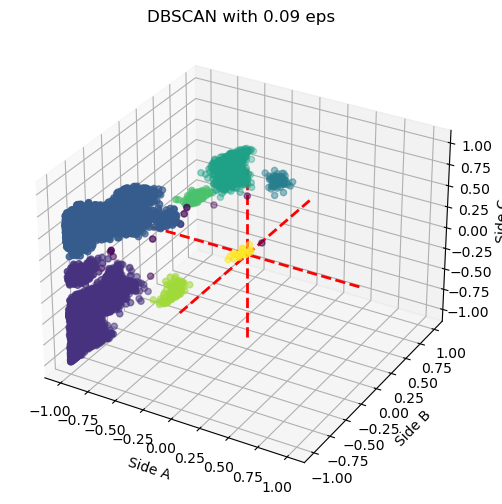

In [ ]:
# Standardize the data (important for DBSCAN)
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data)

# Apply DBSCAN
eps = 0.09  # Epsilon (maximum distance between two samples to be considered in the same neighborhood)
min_samples = 5  # Minimum number of samples in a neighborhood for a data point to be a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(concat_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(concat_data[:, 0], concat_data[:, 1], concat_data[:, 2], c=labels, marker='o')
ax.set_xlabel('Side A')
ax.set_ylabel('Side B')
ax.set_zlabel('Side C')
ax.set_title(f'DBSCAN with {eps} eps')

# Plot red lines along the x, y, and z axes
ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

1
(14, 3)
[-0.55350656 -0.2738966   0.21682535]


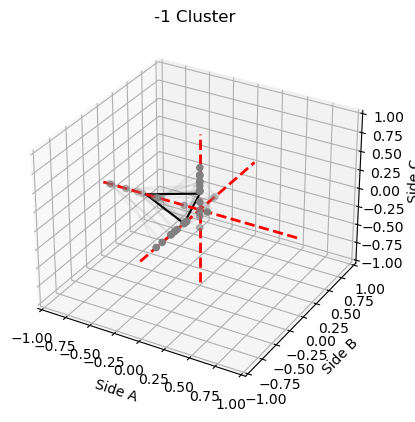

2
(7549, 3)
[-0.95289503 -0.80919307 -0.55572955]


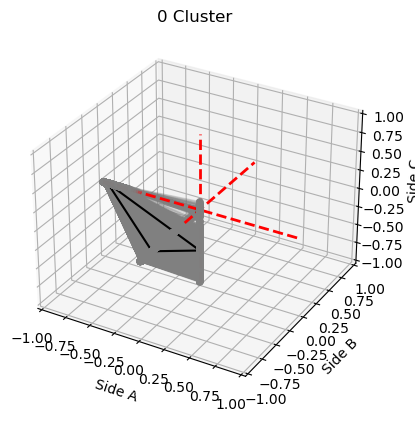

 25%|██▌       | 2/8 [00:12<00:36,  6.04s/it]

3
(9790, 3)
[-0.89790118 -0.71128929  0.55422385]


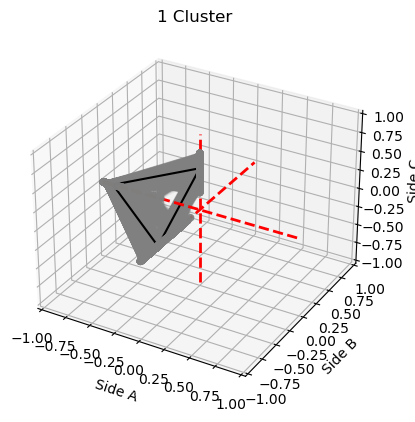

 38%|███▊      | 3/8 [00:27<00:50, 10.14s/it]

4
(72, 3)
[-0.01461918  0.5065814   0.53688017]


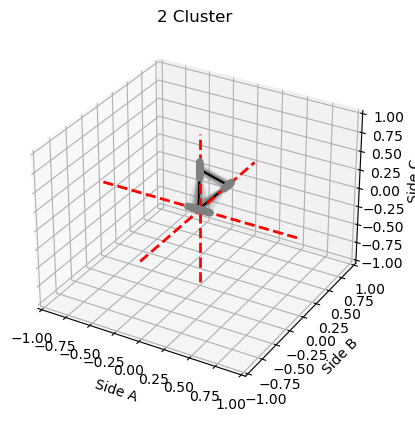

 50%|█████     | 4/8 [00:28<00:25,  6.42s/it]

5
(1556, 3)
[-0.42590393  0.49833656  0.59534529]


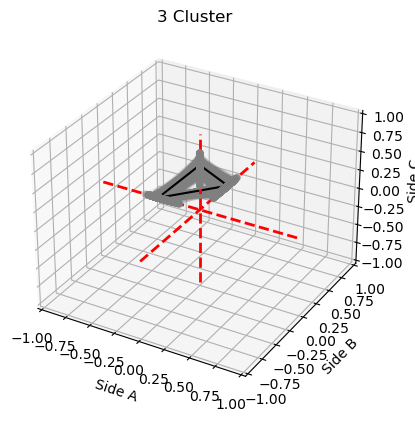

 62%|██████▎   | 5/8 [00:31<00:15,  5.25s/it]

6
(146, 3)
[-0.44418166 -0.01660038  0.52213173]


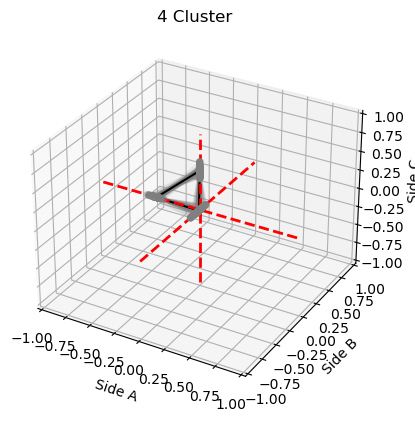

 75%|███████▌  | 6/8 [00:31<00:07,  3.60s/it]

7
(101, 3)
[-0.42731782 -0.39009597 -0.34015961]


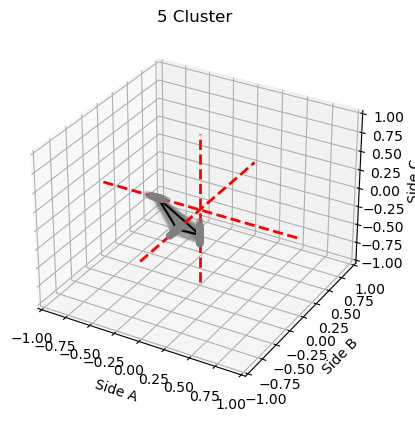

 88%|████████▊ | 7/8 [00:31<00:02,  2.52s/it]

8
(23, 3)
[-0.04674601 -0.01693785  0.00600375]


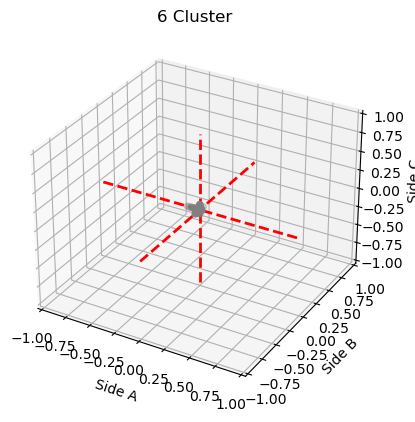

100%|██████████| 8/8 [00:31<00:00,  3.97s/it]


In [ ]:
# Get the number of unique clusters
num_clusters = len(np.unique(labels))
amounts = []

# Plot clusters
for cluster_num in tqdm(range(1, num_clusters + 1)):
    
    # Filter data points belonging to the current cluster
    selected_data = concat_data[labels == cluster_num-2]
    print(cluster_num)
    print(np.shape(selected_data))
    amounts.append(len(selected_data))
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot individual triangles with transparent grey lines
    for i in range(len(selected_data)):
        x = [selected_data[i, 0], 0, 0]
        y = [0, selected_data[i, 1], 0]
        z = [0, 0, selected_data[i, 2]]

        # Plot points
        ax.scatter(x, y, z, marker='o', c='grey')

        # Connect the points to form a triangle with transparent grey lines
        ax.plot([x[0], x[1], x[2], x[0]], [y[0], y[1], y[2], y[0]], [z[0], z[1], z[2], z[0]], c='grey', alpha=0.1)

    # Calculate the average triangle
    average_triangle = np.mean(selected_data, axis=0)
    print(average_triangle)
    x_avg = [average_triangle[0], 0, 0]
    y_avg = [0, average_triangle[1], 0]
    z_avg = [0, 0, average_triangle[2]]

    # Plot the average triangle with black lines
    ax.plot(x_avg + [x_avg[0]], y_avg + [y_avg[0]], z_avg + [z_avg[0]], c='black')

    # Plot red lines along the x, y, and z axes
    ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
    ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
    ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis

    #ax.plot(x_avg, y_avg, z_avg, c='black')
    # Set axis labels
    ax.set_xlabel('Side A')
    ax.set_ylabel('Side B')
    ax.set_zlabel('Side C')
    
    # Set axis limits to range from -1 to 1
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"{cluster_num-2} Cluster")

    # Show the plot
    plt.show()    
    


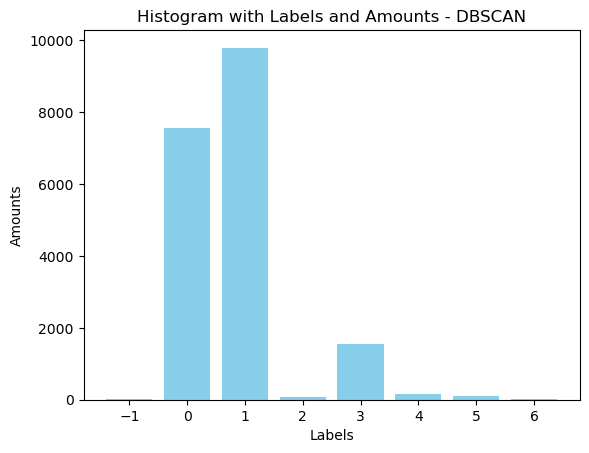

In [ ]:
# Create a bar plot
plt.bar(np.unique(labels), amounts, color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Amounts')
plt.title('Histogram with Labels and Amounts - DBSCAN')

# Show the plot
plt.show()

# SVD Transformation

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


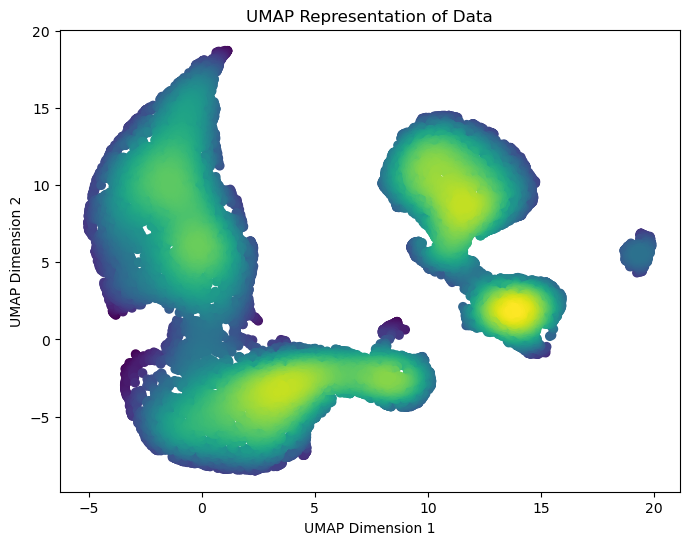

In [25]:
import numpy as np
import umap.umap_ as umap
from scipy.stats import gaussian_kde

# Assuming your data matrix is called 'data' with size (n, 3)
# where n is the number of samples and 3 is the number of features.

# Create a UMAP model with 2 components (dimensions)
umap_model = umap.UMAP(random_state=42,n_components=2)

# Fit the UMAP model to your data and transform it to 2 dimensions
embedding = umap_model.fit_transform(concat_data)

# Calculate KDE
x = embedding[:,0]
y = embedding[:,1]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
first, second, z = x[idx], y[idx], z[idx]

# Plot the embedded data with colors and shapes based on labels
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(first, second, c=z)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Representation of Data')
plt.show()

# first = X[:,0]
# second = X[:,1]
# xy = np.vstack([first, second])
# z = gaussian_kde(xy)(xy)

# idx = z.argsort()
# first, second, z = first[idx], second[idx], z[idx]

# fig, ax = plt.subplots()
# ax.scatter(first, second, c=z, s=50)

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA Plot Colored by Density')
# plt.show()



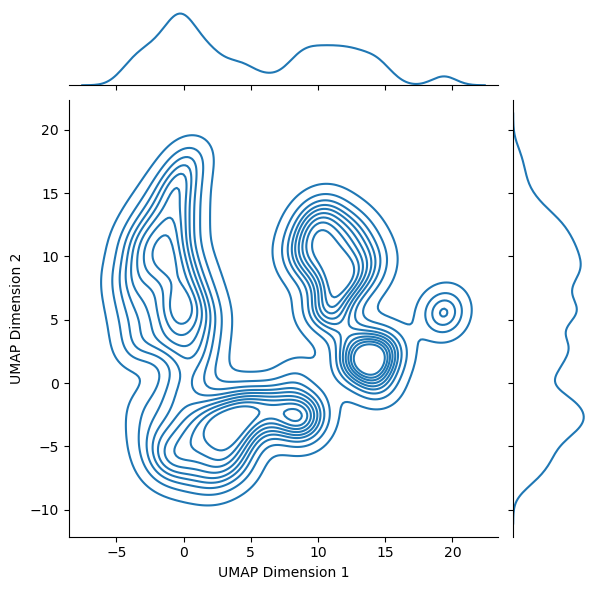

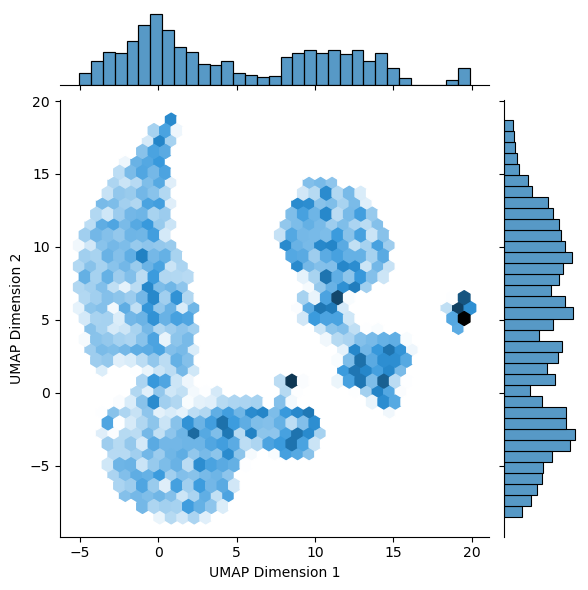

In [24]:
import seaborn as sns
import pandas as pd

# Create a new DataFrame
new_df = pd.DataFrame({'Column1': x, 'Column2': y})
sns.jointplot(x=new_df['Column1'], y=new_df['Column2'], kind='kde')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

sns.jointplot(x=new_df['Column1'], y=new_df['Column2'], kind='hex')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()



/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


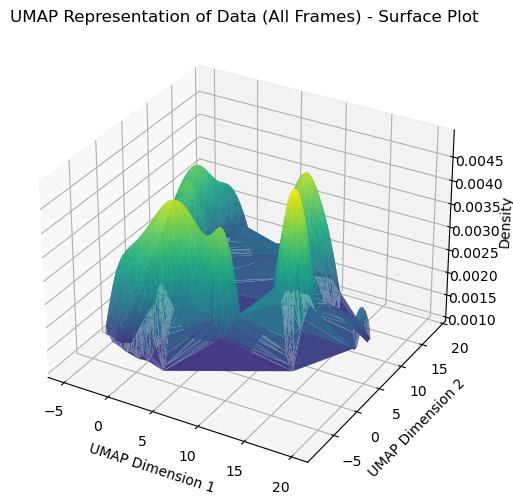

In [14]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

# Assuming your data matrix is called 'data' with size (n, 3)
# where n is the number of samples and 3 is the number of features.

# Create a UMAP model with 2 components (dimensions)
umap_model = umap.UMAP(random_state=42, n_components=2)

# Fit the UMAP model to your data and transform it to 2 dimensions
embedding = umap_model.fit_transform(concat_data)

# Calculate KDE
x = embedding[:, 0]
y = embedding[:, 1]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Plot the embedded data as a surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis')

ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('Density')
ax.set_title('UMAP Representation of Data (All Frames) - Surface Plot')
plt.show()
